In [1]:
%config IPCompleter.use_jedi=False

In [2]:
import os
from loguru import logger
from urllib.parse import quote_plus
from playwright._impl._errors import TimeoutError

from pc_zap_scrapper.v2.scrape import get_estates_from_page, get_html_page, get_number_of_pages, get_number_of_real_estates
from pc_zap_scrapper.v2.database import DatabaseHandler, TableRealEstateInfo


import nest_asyncio
nest_asyncio.apply()

In [3]:
ACTION="venda"
TYPE="imoveis"
LOCALIZATION="mg+pocos-de-caldas"

db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)


soup = get_html_page(f"https://www.zapimoveis.com.br/{ACTION}/{TYPE}/{LOCALIZATION}")
number_of_real_estates = get_number_of_real_estates(soup)
number_of_pages = get_number_of_pages(number_of_real_estates)
logger.info(f"number_of_real_estates = {number_of_real_estates}")
logger.info(f"number_of_pages = {number_of_pages}")

N_EXPECTED_PAGES = 25

for page in range(1, 1+number_of_pages):

    if page > N_EXPECTED_PAGES:
        break

    logger.info(f"scrapping page {page}")
    try:
        estates = await get_estates_from_page(
            action=ACTION,
            type=TYPE,
            localization=LOCALIZATION,
            page=page,
        )
        await db_handler.create_table()
        await db_handler.insert_data(estates)
    except TimeoutError:
        continue

    except:
        logger.error("Não foi possível persistir. Valores duplicados")


await db_handler.close()

2024-11-29 04:00:35.308 | DEBUG    | pc_zap_scrapper.v2.scrape:get_html_page:444 - Requesting info from 'https://www.zapimoveis.com.br/venda/imoveis/mg+pocos-de-caldas'
2024-11-29 04:00:38.142 | INFO     | __main__:<module>:19 - number_of_real_estates = 2374
2024-11-29 04:00:38.143 | INFO     | __main__:<module>:20 - number_of_pages = 23
2024-11-29 04:00:38.143 | INFO     | __main__:<module>:29 - scrapping page 1
Loop 8 | 104 elementos: 100%|██████████| 104/104 [01:14<00:00,  1.39it/s]
2024-11-29 04:02:00.323 | INFO     | __main__:<module>:29 - scrapping page 2
Loop 7 | 103 elementos: 100%|██████████| 103/103 [01:06<00:00,  1.55it/s]
2024-11-29 04:03:15.079 | WARNING  | pc_zap_scrapper.v2.scrape:_get_location:232 - It wa not possible to get locatino info from snippet '<h2 class="l-text l-u-color-neutral-28 l-text--variant-heading-small l-text--weight-medium truncate" data-cy="rp-cardProperty-location-txt" title="Caldas">Caldas</h2>'
2024-11-29 04:03:15.759 | INFO     | __main__:<module

In [4]:

import pandas as pd
import sqlalchemy
from sqlalchemy import insert
from sqlalchemy.orm import declarative_base
from sqlalchemy.ext.asyncio import create_async_engine, AsyncSession
from sqlalchemy.orm import sessionmaker
from sqlalchemy import (
   Column,
   UUID,
   Text,
   TIMESTAMP,
   Double,
   Integer,
   Numeric,
   ARRAY,
)


Base = declarative_base()


class DatabaseHandler:
    def __init__(self, db_params: dict, table: sqlalchemy.orm.decl_api.DeclarativeMeta, echo: bool = False):
        db_url = (
            f"postgresql+asyncpg://{db_params['user']}:{db_params['password']}@"
            f"{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
        )
        self.table = table
        self.engine = create_async_engine(db_url, echo=echo)
        self.async_session = sessionmaker(self.engine, class_=AsyncSession, expire_on_commit=False)

    async def create_table(self):
        async with self.engine.begin() as conn:
            await conn.run_sync(Base.metadata.create_all)

    async def insert_data(self, df: pd.DataFrame):
        records = df.to_dict(orient="records")

        async with self.async_session() as session:
            async with session.begin():
                await session.execute(insert(self.table).values(records))
                await session.commit()
    
    async def query(self, sql_query: str) -> pd.DataFrame:
        async with self.engine.connect() as conn:
            result = await conn.execute(sqlalchemy.text(sql_query))
            rows = result.fetchall()
            columns = result.keys()
            df = pd.DataFrame(rows, columns=columns)
            return df


    async def close(self):
        await self.engine.dispose()


In [5]:
db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)


In [6]:
sql_query = """
SELECT * FROM real_estate_info
"""

data = await db_handler.query(sql_query)

await db_handler.close()

In [9]:
data["price"] = data["price"].astype(float) 
data["mean_price"] = data.eval("price/floor_size")

In [18]:
!pip install matplotlib -qqq
import matplotlib

<Axes: >

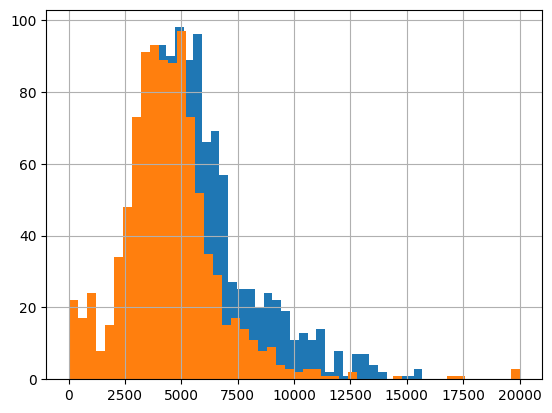

In [24]:
data[data["type"]=="Apartamento"].groupby("estate_id").agg(mean_price=("mean_price", "mean"))["mean_price"].clip(0,20000).hist(bins=50)

data[data["type"]=="Casa"].groupby("estate_id").agg(mean_price=("mean_price", "mean"))["mean_price"].clip(0,20000).hist(bins=50)

In [30]:
unique_data = data.groupby("estate_id").last()

In [51]:
temp = unique_data.loc[(unique_data["neighbor"]=="Dom Bosco") & (unique_data["type"]=="Casa")]


In [39]:
unique_data["neighbor"].value_counts().head(60)

neighbor
Centro                               298
Jardim dos Estados                   122
Jardim das Hortênsias                112
Jardim Country Club                  100
São Benedito                          99
Jardim Quisisana                      97
Jardim Bandeirantes                   83
Parque Vivaldi Leite Ribeiro          62
Jardim Elvira Dias                    54
Jardim Cascatinha                     54
Residencial Veredas                   53
Jardim Europa                         51
Santa Ângela                          50
Residencial Morumbí                   46
Jardim Vitória                        45
Residencial Summer Ville              39
Estância Poços de Caldas              36
Campo das Antas                       33
Vila Togni                            32
Bortolan                              31
Jardins de Florença                   31
Jardim Centenário                     30
Parque Primavera                      29
Nossa Senhora Aparecida               28
Residen

# Sandbox

In [3]:
import pandas as pd

In [4]:
pd.options.display.max_columns = None

In [5]:
ACTION="venda"
TYPE="imoveis"
LOCALIZATION="mg+pocos-de-caldas"


In [ ]:

page = 1

estates = await get_estates_from_page(
    action=ACTION,
    type=TYPE,
    localization=LOCALIZATION,
    page=page,
)

In [ ]:
estates

In [8]:
from pc_zap_scrapper.v2.scrape import scrape_estate_divs_from_page, _get_snippet

In [9]:
divs = await scrape_estate_divs_from_page(
    action=ACTION,
    type=TYPE,
    localization=LOCALIZATION,
    page=1,
)

Loop 8 | 113 elementos: 100%|██████████| 113/113 [01:11<00:00,  1.57it/s]


In [10]:
div = divs[0]

In [11]:
from pc_zap_scrapper.v2.scrape import _get_type

In [14]:
def _get_type(div):

    if snippet := _get_snippet(div):
        type = _get_type_from_snippet(snippet)

    if type:
        return type


    if "apartamento" in str(div).lower():
        return "Apartamento"

    if "casa" in str(div).lower():
        return "Casa"

    if "cobertura" in str(div).lower():
        return "Apartamento"

    if "flat" in str(div).lower():
        return "Flat"

    if "chacara" in unidecode(str(div).lower()):
        return "Rural"

    if "sitio" in unidecode(str(div).lower()):
        return "Rural"

    if "fazenda" in unidecode(str(div).lower()):
        return "Rural"


def _get_type_from_snippet(snippet):
    if not snippet:
        logger.warning("No snippet found")
        return None
    snippet = str(snippet)
    is_rural = ("fazenda" in snippet.lower()) or ("sítio" in snippet.lower()) or ("chácara" in snippet.lower())
    is_comercial = ("ponto comercial" in snippet.lower()) or ("loja" in snippet.lower()) or ("box" in snippet.lower())
    is_lote = ("lote" in snippet.lower()) or ("terreno" in snippet.lower())

    if "apartamento" in snippet.lower():
        return "Apartamento"

    if is_rural:
        return "Rural"

    if "casa" in snippet.lower():
        return "Casa"

    if "flat" in snippet.lower():
        return "Flat"

    if "cobertura" in snippet.lower():
        return "Apartamento"

    if is_comercial:
        return "Comercial"

    if is_lote:
        return "Lote"

In [15]:
snippet = _get_snippet(div)
type = _get_type(div)

type

'Casa'

In [19]:
snippet

'Centro, Poços de Caldas'

In [13]:

def _format_neighbor_name(text: str) -> str:
    if text:
        return unidecode(text.strip().lower())
    return None

pc_neighbors_latlong = (
    pd.read_parquet(resources.files("pc_zap_scrapper").joinpath("datasets/external/neighbor_latlong.parquet"))
    .set_index("neighborhood")
    .to_dict(orient="index")
)

pc_neighbors_latlong = {_format_neighbor_name(k): v for k, v in pc_neighbors_latlong.items() if k}

search_date = search_date or datetime.now()
prices = _get_prices(div)
snippet = _get_snippet(div)
location = _get_location(div)
type = _get_type(snippet)
neighbor = location.get("neighbor")
formatted_neighbor_name = _format_neighbor_name(neighbor)
latlong = pc_neighbors_latlong.get(formatted_neighbor_name, {}) if formatted_neighbor_name else {}
latitude = latlong.get("latitude", None)
longitude = latlong.get("longitude", None)


In [14]:
snippet

'Jardim Quisisana, Poços de Caldas'

In [ ]:
# @suppress_errors_and_log
# def _get_location(div):
#     if subtitle := div.find("h2", attrs={"data-testid": "card-header"}):
#         if spans := subtitle.findAll("span"):
#             texts = [x.text for x in spans]
#             *street, neighbor, city, state = [x.strip() for x in texts[1].replace("-", ",").split(",")]
#             return {
#                 "street": " - ".join(street),
#                 "neighbor": neighbor,
#                 "city": city,
#                 "state": state,
#             }

#     if subtitle := div.find("h2"):
#         elements = str(subtitle.text).split[","]
#         if len(elements) == 2:
#             return {
#                 "street": None,
#                 "neighbor": elements[0],
#                 "city": elements[1],
#                 "state": None,
#             }
#         logger.warning(f"It wa not possible to get locatino info from snippet '{subtitle}'")
#     return {
#         "street": None,
#         "neighbor": None,
#         "city": None,
#         "state": None,
#     }



In [12]:
div

<div data-position="1" data-type="SUPER PREMIUM"><div class="ListingCard_result-card__Pumtx"><a class="ListingCard_result-card__Pumtx ListingCard_result-card__highlight__UgAvU ListingCard_result-card__highlight--super__8WmjB" data-id="2759584336" href="https://www.zapimoveis.com.br/imovel/venda-terreno-lote-condominio-jardins-de-florenca-pocos-de-caldas-mg-276m2-id-2759584336/" itemprop="url" itemscope="" itemtype="https://schema.org/House" target="_blank"><div class="BaseCard_card__wrapper__AKWue"><div class="BaseCard_card__Ci4Ny BaseCard_card--horizontal__GgDlY" data-testid="card"><div class="BaseCard_card-carousel__VFcJU"><div class="l-carousel-image" data-cy="rp-cardProperty-image-img"><div class="l-carousel-image__container"><ul class="l-carousel-image__list" style="transform: translateX(0px);"><li aria-hidden="false"><img alt="Imagem do imóvel" class="l-image" fetchpriority="low" itemprop="image" loading="lazy" src="https://resizedimgs.zapimoveis.com.br/crop/614x297/vr.images.sp/

In [20]:
def _get_snippet(div):
    if subtitle := div.find("h2", attrs={"data-testid": "card-header"}):
        if spans := subtitle.findAll("span"):
            texts = [x.text for x in spans]
            return texts[0].split(",")[0]

    if subtitle := div.find("h2"):
        return subtitle.text

In [21]:
div.find("h2")

<h2 class="l-text l-u-color-neutral-28 l-text--variant-heading-small l-text--weight-medium truncate" data-cy="rp-cardProperty-location-txt" title="Jardins de Florença, Poços de Caldas">Jardins de Florença, Poços de Caldas</h2>

In [22]:
_get_snippet(div)

'Jardins de Florença, Poços de Caldas'

In [15]:
div.find("h2")

<h2 class="l-text l-u-color-neutral-28 l-text--variant-heading-small l-text--weight-medium truncate" data-cy="rp-cardProperty-location-txt" title="Jardins de Florença, Poços de Caldas">Jardins de Florença, Poços de Caldas</h2>

# Especificos

In [3]:
ACTION="venda"
TYPE="imoveis"
LOCALIZATION="mg+pocos-de-caldas"

db_params = dict(
    user=os.getenv("PSQL_USERNAME"),
    password=quote_plus(os.getenv("PSQL_PASSWORD")),
    host=os.getenv("PSQL_HOST"),
    port=os.getenv("PSQL_PORT"),
    dbname=os.getenv("PSQL_NAME"),
)

db_handler = DatabaseHandler(db_params, table=TableRealEstateInfo, echo=False)


soup = get_html_page(f"https://www.zapimoveis.com.br/{ACTION}/{TYPE}/{LOCALIZATION}")
number_of_real_estates = get_number_of_real_estates(soup)
number_of_pages = get_number_of_pages(number_of_real_estates)
logger.info(f"number_of_real_estates = {number_of_real_estates}")
logger.info(f"number_of_pages = {number_of_pages}")

N_EXPECTED_PAGES = 25

for page in [9,14,17]:

    if page > N_EXPECTED_PAGES:
        break

    logger.info(f"scrapping page {page}")
    try:
        estates = await get_estates_from_page(
            action=ACTION,
            type=TYPE,
            localization=LOCALIZATION,
            page=page,
        )
        await db_handler.create_table()
        await db_handler.insert_data(estates)
    except TimeoutError:
        continue

    except:
        logger.error("Não foi possível persistir. Valores duplicados")


await db_handler.close()

2024-11-30 23:41:54.470 | DEBUG    | pc_zap_scrapper.v2.scrape:get_html_page:444 - Requesting info from 'https://www.zapimoveis.com.br/venda/imoveis/mg+pocos-de-caldas'
2024-11-30 23:41:58.164 | INFO     | __main__:<module>:19 - number_of_real_estates = 2308
2024-11-30 23:41:58.165 | INFO     | __main__:<module>:20 - number_of_pages = 23
2024-11-30 23:41:58.166 | INFO     | __main__:<module>:29 - scrapping page 9
Inicializando:   0%|          | 0/200 [00:13<?, ?it/s]
2024-11-30 23:42:13.317 | INFO     | __main__:<module>:29 - scrapping page 14
Loop 7 | 105 elementos: 100%|██████████| 105/105 [01:05<00:00,  1.61it/s]
2024-11-30 23:43:29.286 | INFO     | __main__:<module>:29 - scrapping page 17
Loop 7 | 105 elementos: 100%|██████████| 105/105 [01:07<00:00,  1.56it/s]
